In [21]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline



In [383]:
class LaneDetection(object):
    
    def __init__(self, cal_images):
        self.cal_images = cal_images
        self.calibrate_camera()
    
    def set_obj_and_img_points(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.
    
        # Step through the list and search for chessboard corners
        for fname in self.cal_images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
#             if not ret: print(fname)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    def calibrate_camera(self):
        self.set_obj_and_img_points()
        if len(self.objpoints) == 0 or len(self.imgpoints) == 0:
            raise Exception("Calibration Failed!")
        
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        
        self.mtx = mtx
        self.dist = dist

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, mtx)
    
    def to_gray(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def top_view(self, img):
        # Use the OpenCV undistort() function to remove distortion
        undist = self.undistort(img)
        
        # Convert undistorted image to grayscale
        gray = self.to_gray(undist)
        
    def abs_sobel_thresh(self, gray, orient='x', thresh_min=40, thresh_max=200, ksize=5):
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
        
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output
    
    def mag_thresh(self, gray, thresh_min=40, thresh_max=250, ksize=7):
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        
        # Rescale to 8 bit
        scale_factor = np.max(gradmag) / 255 
        
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        
        binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

        # Return the binary image
        return binary_output
    
    def dir_threshold(self, gray, ksize=7, thresh=(0.7, 1.3)):

        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
        binary_output =  np.zeros_like(absgraddir)
        
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def gradient_binary(self, gray, thresh_min=40, thresh_max=250, ksize=7, thresh=(0.7, 1.3)):
        # Apply each of the thresholding functions
        gradx = self.abs_sobel_thresh(gray, orient='x',thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

#         grady = self.abs_sobel_thresh(gray, orient='y', thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

#         mag_binary = self.mag_thresh(gray, thresh_min=thresh_min, thresh_max=thresh_max, ksize=ksize)

#         dir_binary = self.dir_threshold(gray, ksize=ksize, thresh=thresh)
        
#         combined = np.zeros_like(dir_binary)
        
#         combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        # Return the result
        return gradx
        
    def binary_transform(self, img, thresh_min=40, thresh_max=250, ksize=7, thresh=(0.7, 1.3), hls_thresh=(175, 255)):
        
        gray = self.to_gray(img)
        
        # Threshold gradient
        sxbinary = self.gradient_binary(gray)
    
#         # Threshold color channel
#         s_binary = self.to_hls(img)
    
#         # Stack each channel to view their individual contributions in green and blue respectively
#         # This returns a stack of the two binary images, whose components you can see as different colors
#         color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
#         # Combine the two binary thresholds
#         combined_binary = np.zeros_like(sxbinary)
#         combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
        # Return the result
        return sxbinary
    
    def to_hls(self, img, hls_thresh=(50, 200)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        
        s_channel = hls[:,:,2]
        
        binary_output = np.zeros_like(s_channel)
        
        binary_output[(s_channel > hls_thresh[0]) & (s_channel <= hls_thresh[1])] = 1
        
        return binary_output
    
    def perspective_transform(self, binary):
        img_size = (binary.shape[1], binary.shape[0])

        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        return cv2.warpPerspective(binary, M, img_size)
    
    def detect_lines(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)

        leftx_base = np.argmax(histogram[:midpoint])

        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
    
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            
            win_y_high = binary_warped.shape[0] - window*window_height
            
            win_xleft_low = leftx_current - margin
            
            win_xleft_high = leftx_current + margin
            
            win_xright_low = rightx_current - margin
            
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
            
        right_lane_inds = np.concatenate(right_lane_inds)
            
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
            
        lefty = nonzeroy[left_lane_inds] 
            
        rightx = nonzerox[right_lane_inds]
            
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
            
        right_fit = np.polyfit(righty, rightx, 2)
            
        return left_fit, right_fit
        

In [384]:
ld = LaneDetection(glob.glob('camera_cal/calibration*.jpg'))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:187: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

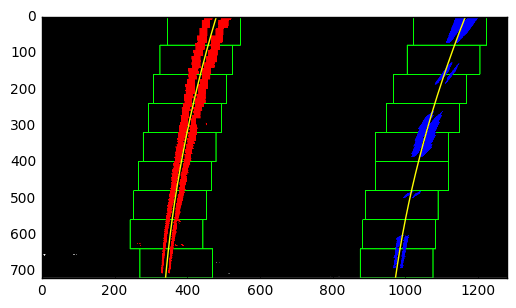

In [385]:
img = cv2.imread('test_images/test3.jpg')
# dst = ld.dir_threshold(lane_detection.to_gray(img), ksize=7, thresh=(0.7, 1.3))
# dst = ld.abs_sobel_thresh(lane_detection.to_gray(img), orient='x', thresh_min=40, thresh_max=250, ksize=7)
# dst = ld.mag_thresh(lane_detection.to_gray(img), thresh_min=40, thresh_max=250, ksize=7)
# dst = ld.binary_transform(lane_detection.to_gray(img))
binary = ld.binary_transform(img)
binary_warped = ld.perspective_transform(binary)
left_fit, right_fit = ld.detect_lines(binary_warped)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# # cv2.imwrite('output_images/binary_test3.jpg', dst * 255)
# # plt.imshow(dst, interpolation='nearest', aspect='auto', cmap='gray')
# # plt.imshow(lane_detection.to_gray(img), interpolation='nearest', aspect='auto', cmap='gray')
# # Generate x and y values for plotting

# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)